# MATH 210 Project I: Approximating Definite Integrals with `scipy.integrate`

SciPy is the one of the core scientific computing packages in Python and the subpackage `scipy.integrate` addresses two kinds of computational problems (see the [documentation](http://docs.scipy.org/doc/scipy/reference/integrate.html)):

1. Approximate definite integrals: $I = \int_a^b f(x) \, dx$
2. Approximate solutions of systems of ordinary differential equations

**Our goal** in this notebook is to explore **three functions** in the subpackage `scipy.integrate` which **approximate definite integrals**. In particular, we will explore the **trapezoid rule** and **Simpson's rule**, and introduce the implementation of the **QUADPACK Fortran library** for computing integrals. By the end of the notebook, the reader will be able to implement the following functions to approximate definite integrals:

* `scipy.integrate.trapz` (see the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapz.html))
* `scipy.integrate.simps` (see the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simps.html))
* `scipy.integrate.quad` (see the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html))

Our main conclusion is that `quad` is the most accurate of the 3 methods.

## Contents

1. Trapezoid Rule: `trapz`
2. Simpson's Rule: `simps`
3. QUADPACK Fortran Library: `quad`
4. Exercises

In [1]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Trapezoid Rule

### Formula for the trapezoid rule

The [trapezoid rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) approximates the area under the curve $y = f(x)$ on the interval $[a,b]$ by choosing a fixed partition $x_0 = a, x_1, \dots, x_n = b$ and summing the areas of the trapezoids at each subinterval

$$
\int_a^b f(x) \, dx \approx \sum_{i=0}^{n-1} \left( \, (x_{i+1} - x_i) f(x_i) +  (x_{i+1} - x_i) ( f(x_{i+1}) - f(x_i) ) / 2 \, \right)
$$

Note the first term in the expression of the series represents the area of the rectangle of height $f(x_i)$ and width $x_{i+1} - x_i$, and the second term represents the area of the triangle of height $f(x_{i+1}) - f(x_i)$ (possibly negative). We can simplify the expression as

$$
\int_a^b f(x) \, dx \approx \frac{1}{2} \sum_{i=0}^{n-1} ( \, x_{i+1} - x_i \, ) ( \ f(x_{i+1}) + f(x_i) \, )
$$

and we note that the accuracy of the trapezoid rule increases as the number of points in the partition of the interval $[a,b]$ increases as shown in the following illustration from [Wikipedia](https://en.wikipedia.org/wiki/Trapezoidal_rule):

![trapz](https://upload.wikimedia.org/wikipedia/en/a/ab/Trapezium.gif)

### Define our own function to implement the trapezoid rule

Note that the trapezoid rule is given by an explicit formula:

$$
\int_a^b f(x) \, dx \approx \frac{1}{2} \sum_{i=0}^{n-1} (x_{i+1} - x_i) ( f(x_{i+1}) + f(x_i) )
$$

therefore we can write our own function to implement the trapezoid rule:

In [2]:
def my_trapz(y,x):
    return sum([ (x[i+1] - x[i])*(y[i+1] + y[i]) for i in range(0,len(x)-1) ])*0.5

### `scipy.integrate.trapz`

The function `trapz` implements the trapezoid rule to approximate the definite integral $\int_a^b f(x) \, dx$. It takes at least one input array `y` which represents the $y$ values of the given function $f$. The first element of the array is the value $f(a)$ and the last entry in the array is the value $f(b)$. The second input is the corresponding array `x` of $x$ values. The first entry of the array is $a$ and the last entry is $b$.

There are 2 more optional inputs however they are not very useful. You can see the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapz.html) or enter `scipy.integrate.trapz?`

Finally, the best way to learn how to use any function is to work out some examples!

### Example: Gaussian Integral

Let's approximate the definite integral $\int_0^{100} e^{-x^2} dx$ using the function `trapz` as well as our own function `my_trapz` defined above.

Recall, the function $y = e^{-x^2}$ is known as the Gaussian function and defines the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution).

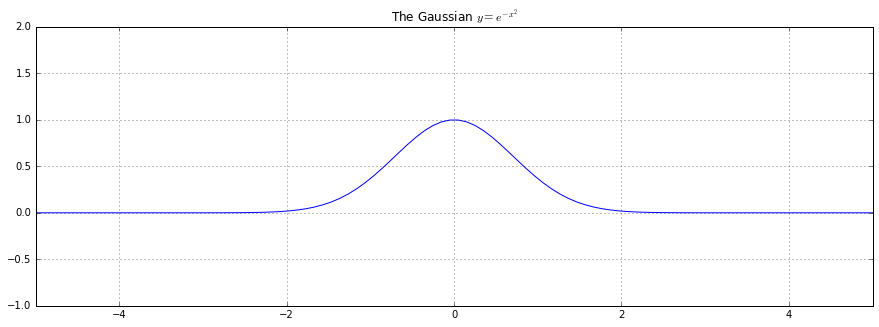

In [3]:
x = np.linspace(-5,5,100)
y = np.exp(-x**2)
plt.figure(figsize=[15,5])
plt.plot(x,y), plt.title('The Gaussian $y = e^{-x^2}$'), plt.xlim([-5,5]), plt.ylim([-1,2]), plt.grid('on');

Before we approximate the definite integral, recall the well-known [Gaussian integral](https://en.wikipedia.org/wiki/Gaussian_integral):

$$
\int_0^{\infty} e^{-x^2} dx = \frac{\sqrt{\pi}}{2}
$$

Therefore we expect the function `scipy.integrate.trapz` to return a value close to:

In [4]:
np.pi ** 0.5 / 2

0.8862269254527579

We create an array `x` of 1000 evenly-spaced points from 0 to 100 and the corresponding array `y` of values of $y = e^{-x^2}$ and then pass the arrays into the function `scipy.integrate.trapz`:

In [5]:
num_points = 1000
x = np.linspace(0,100,num_points)
y = np.exp(-x**2)
spi.trapz(y,x)

0.88622692545275805

Finally, let's approximate the integral using our own function `my_trapz`:

In [6]:
my_trapz(y,x)

0.88622692545275772

Our result is exactly the same as expected! 

## 2. Simpson's Rule

### Formula for Simpson's rule

[Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) approximates a definite integral $\int_a^b f(x) \, dx$ by replacing $f(x)$ by a quadratic polynomial $p(x)$ which has the same values as $f(x)$ at $x=a$, $x=b$ and the midpoint $x=(b-a)/2$. The result is:

$$
\int_a^b f(x) \, dx \approx \frac{b-a}{6} \left( f(a) + 4 \ f \hspace{-1mm} \left( \hspace{-0.5mm} \frac{a+b}{2} \hspace{-0.5mm} \right) + f(b) \right)
$$


However, the accuracy is increased when Simpson's rule is applied to multiple subintervals of $[a,b]$. This is known as [composite Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule#Composite_Simpson.27s_rule)
and is demonstrated in the following illustration from [Wikipedia](https://en.wikipedia.org/wiki/Simpson%27s_rule):

![simps](https://upload.wikimedia.org/wikipedia/en/6/67/Simpsonsrule2.gif)


The formula for the composite Simpson's rule is given by

$$
\int_a^b f(x) \, dx \approx \frac{h}{3} \left[ f(a) + 2 \sum_{i=1}^{n/2-1} f(x_{2i}) + \sum_{j=1}^{n/2} f(x_{2j-1}) + f(b) \right]
$$

where $x_0 = a, x_1, \dots , x_n=b$ is a partition of the interval $[a,b]$ into an even number $n$ of subintervals of width $h = x_{i+1} - x_i$.

### `scipy.integrate.simps`

The function `scipy.integrate.simps` approximates a definite integral by the composite Simpson's rule and it operates similarly to `trapz`. The first input is an array of $y$ values and the second input is the array of corresponding $x$ values where the first entry in the array is the value $a$ and the last entry is the value $b$. See the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simps.html) for more information. Let's explore some examples to see how to use the function and compare it to `trapz`.

### Example: $\int_1^e \ln(x) \, dx$

Let's approximate the integral $\int_1^e \ln(x) \, dx$ using both functions `trapz` and `simps` (as well as our function `my_trapz)` and compare the results.

Using integration by parts, we know that $\int \ln(x) \, dx = x \ln(x) - x + C$ therefore

$$
\int_1^e \ln(x) \, dx = 1
$$

In [7]:
x = np.linspace(1,np.exp(1),101)
y = np.log(x)

In [8]:
spi.trapz(y,x)

0.9999844474702988

In [9]:
spi.simps(y,x)

0.99999999908004888

In [10]:
my_trapz(y,x)

0.99998444747029858

Composite Simpson's rule wins!

### Example: $\int_{\pi/4}^{3\pi/4} \frac{1}{\sin x}\,  dx$

Let's approximate the integral $\int_{\pi/4}^{3\pi/4} \frac{1}{\sin x} dx$. Using integration by parts, we know that

$$
\int \frac{1}{\sin x} \, dx = \frac{1}{2} \ln \left| \frac{\cos x - 1}{\cos x + 1} \right| + C
$$

therefore

$$
\int_{\pi/4}^{3\pi/4} \frac{1}{\sin x} \, dx = 2 \ln \left( \sqrt{2} + 1 \right) \approx 1.7627471740390859
$$


In [11]:
2 * np.log(2**0.5 + 1)

1.7627471740390859

In [12]:
x = np.linspace(np.pi/4,3*np.pi/4,101)
y = 1/np.sin(x)

In [13]:
spi.trapz(y,x)

1.7628053286104757

In [14]:
spi.simps(y,x)

1.7627471845520835

In [15]:
my_trapz(y,x)

1.7628053286104766

Composite Simpson's rule wins again!

## 3. QUADPACK Fortran Library

The function `scipy.integrate.quad` works differently than `trapz` and `simps` (see the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)). In particular:

1. Instead of inputting arrays of $x$ and $y$ values, the function `quad` takes a function $f$ and the interval endpoints $a$ and $b$ (as well as other optional inputs)
2. The function `quad` returns a tuple of length 2: the first value in the tuple is the approximate value of the definite integral, and the second value is an estimate for the absolute error of the approximation

The function `quad` approximates a definite integral using the Fortran library QUADPACK. Exactly how QUADPACK works is too complex for this tutorial however there is an entry on [Wikipedia](https://en.wikipedia.org/wiki/QUADPACK) describing QUADPACK. **The main thing to remember is that QUADPACK is highly accurate and optimized!**

### Example: $\int_0^{\pi} ( 3\sin x + \sin 2x ) \, dx$

Let's compute the integral $\int_0^{\pi} ( 3\sin x + \sin 2x ) \, dx$ using all 3 functions `trapz`, `simps` and `quad`. But first, let's plot the function $f(x) = 3\sin x + \sin 2x$:

In [16]:
def f(x):
    return 3*np.sin(x) + np.sin(2*x)

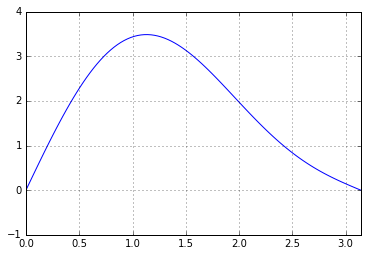

In [17]:
x = np.linspace(0,np.pi,100)
y = f(x)
plt.plot(x,y)
plt.xlim([0,np.pi]), plt.ylim([-1,4]), plt.grid('on');

We know that $\int_0^{\pi} (3\sin(x) + \sin(2x)) \, dx = 6$ and we compute:

In [18]:
spi.trapz(y,x)

5.9994964916819766

In [19]:
my_trapz(y,x)

5.9994964916819802

In [20]:
spi.simps(y,x)

5.9999999070496095

In [21]:
# Note that the first input is the function f that we defined above
spi.quad(f,0,np.pi)

(6.0, 6.661338147750939e-14)

QUADPACK wins! And is exact!!! Note that we can extract just the value of the definite integral returned by `quad` by the following:

In [22]:
result = spi.quad(f,0,np.pi)
result[0]

6.0

## 4. Exercises

**Exercise 1.** Approximate the definite integral $\int_{-1}^1 \sqrt{1 - x^2} \, dx$ using all 3 functions `trapz`, `simps` and `quad`. Compare the results to the true value $\pi/2$. Which function computed the most accurate approximation?

**Exercise 2.** Recall the [square wave](https://en.wikipedia.org/wiki/Square_wave).

(a) Find the exact value of definite integral

$$
\int_0^{1/2} \frac{4}{\pi} \left( \sin(2 \pi x) + \frac{ \sin(6 \pi x )}{ 3 } + \frac{ \sin(10 \pi x )}{ 5 } \right) \ dx
$$

(b) Use all 3 functions `trapz`, `simps` and `quad` to approximate the definite integral in part (a).

**Exercise 3.** Use all 3 functions `trapz`, `simps` and `quad` to approximate the integral $\int_0^1 x e^{-x} dx$. Use integration by parts to solve the integral and find the exact value of the definite integral.